In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

# Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

# Считывание данных

In [2]:
data = pd.read_csv('data/_train_sem09.csv')

Обработка данных по условию задачи не требуется, сразу перейдем к построению моделей.

In [3]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='Activity', ylabel='count'>

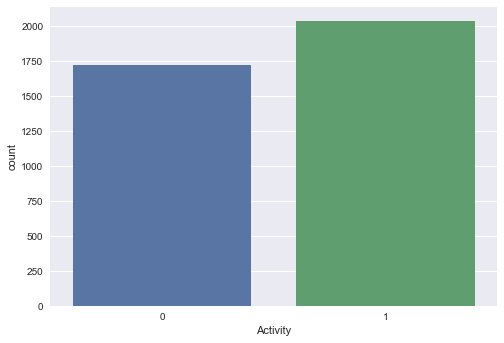

In [4]:
sns.countplot(data=data, x='Activity')

в целом классы сбалансированы и стратифицировать выборки не обязательно, но сделаем разделение с стратификацией

In [5]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# Построение базовых моделей

Построим две базовых модели: логистическая регрессия и случайный лес, для которых далее будем подбирать гиперпараметры

In [7]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


In [8]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренинговом наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренинговом наборе: 1.00
f1_score на тестовом наборе: 0.81


# Подбор гиперпараметров разными методами

### Подбор гиперпараметров с помощью GridSearchCV

In [16]:
#подбор для логистической регрессии
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': list(np.linspace(0.01, 1, 10, dtype=float))
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 3.97 s
Wall time: 1h 1min 39s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.12, 'penalty': 'l2', 'solver': 'lbfgs'}


Для логистической регрессии удалось немного улучшить метрики с помощью метода подбора GridSearchCV, но на это потребовалось очень много времени.

In [13]:
# подбор для случайного леса
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 4.08 s
Wall time: 3min 23s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 130}


Удалось немного улучшить метрику с помощью подбора гиперпараметров. Метрика стала 0,82 вместо 0,81, при этом на подбор параметров потребовалось 3,5 минуты.
Попробуем подобрать параметры другими методами.

### Подбор гиперпараметров с помощью RandomizedSearchCV

In [14]:
#подбор для логистической регрессии
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_train_pred = random_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 20.7 s
Wall time: 7min 49s
f1_score на обучающем наборе: 0.85
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}


удалось немного улучшить метрику для логистической регрессии с помощью подбора параметров путем RandomizedSearchCV.
На что ушло в 10 раз меньше времени чем с помощью GridSearch

In [15]:
#подбор для случайного леса
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.56 s
Wall time: 50.3 s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 7, 'max_depth': 20}


удалось немного улучшить метрику для случайного леса с помощью подбора параметров путем RandomizedSearchCV.
На что ушло времени в три раза меньше чем для GridSearch. При этом результат метрики такой же как для GridSearch

### Подбор гиперпараметров с помощью Hyperopt

#### Подбор для логистической регрессии

In [37]:
# зададим пространство поиска гиперпараметров
pen = ['l2', 'none']
sol = ['lbfgs', 'sag']
space_lr = {'penalty': hp.choice('penalty', ('l2', 'none')) ,
              'solver': hp.choice('solver', 
              ('lbfgs', 'sag')),
              'C': hp.uniform('C',  low=0.01, high=1),  
            }  

In [38]:
# зафксируем параметры
random_state = 42
max_iter=1000
# зададим функцию для поиска параметров
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state, max_iter=max_iter):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
          'solver': params['solver'], 
          'C': float(params['C'])
          } 
              
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=max_iter)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    #score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [39]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



  5%|▌         | 1/20 [00:06<02:12,  6.96s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 20%|██        | 4/20 [01:09<04:59, 18.74s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



 25%|██▌       | 5/20 [01:15<03:32, 14.18s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



 30%|███       | 6/20 [02:07<06:19, 27.09s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



 35%|███▌      | 7/20 [02:57<07:29, 34.54s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|████      | 8/20 [02:59<04:51, 24.32s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



 45%|████▌     | 9/20 [03:05<03:25, 18.71s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 55%|█████▌    | 11/20 [03:39<02:26, 16.28s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



 60%|██████    | 12/20 [04:32<03:39, 27.42s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▌  | 15/20 [05:29<01:56, 23.39s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



 80%|████████  | 16/20 [05:36<01:13, 18.45s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



 85%|████████▌ | 17/20 [06:44<01:40, 33.44s/trial, best loss: -0.9914057704112953]

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [07:46<00:00, 23.31s/trial, best loss: -0.9914057704112953]
Наилучшие значения гиперпараметров {'C': 0.6239178076998746, 'penalty': 1, 'solver': 0}
CPU times: total: 8min 13s
Wall time: 7min 46s


In [40]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state,
    max_iter=max_iter, 
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=float(best['C'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.71


c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Метрику улучшить не удалось, попробуем сделать это другим методом.

#### Подбор для случайного леса

In [13]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [14]:
# зафксируем random_state
random_state = 42
# зададим функцию для поиска параметров
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [15]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [05:39<00:00, 16.98s/trial, best loss: -0.8097798646226206]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 200.0}
CPU times: total: 1min 22s
Wall time: 5min 39s


In [16]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.83


Метрику при построении случайного леса удалось еще улучшить, при этом потрачено не так много времени на подбор параметров, а так же можно попробовать продолжить улучшение, основываясь на полученных ранее результатах.

### Подбор гиперпараметров с помощью Optuna

#### Подбор для логистической регрессии

In [41]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C', 0.01, 1, step=0.01)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state,
                                          max_iter=1000)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [42]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2023-02-28 23:24:58,377] A new study created in memory with name: LogisticRegression
[I 2023-02-28 23:25:02,149] Trial 0 finished with value: 0.8807339449541284 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.79}. Best is trial 0 with value: 0.8807339449541284.
[I 2023-02-28 23:25:31,412] Trial 1 finished with value: 0.8795843520782396 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.7000000000000001}. Best is trial 0 with value: 0.8807339449541284.
c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-02-28 23:26:23,959] Trial 2 finished with value: 0.925993883792049 and parameters: {'penal

CPU times: total: 6min 45s
Wall time: 4min 48s


In [43]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.53}
f1_score на обучающем наборе: 0.99


c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


f1_score на тестовом наборе: 0.75


c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


метрику так же улучшить не получилось, но она лучше чем у hyperopt.

#### Подбор для случайного леса

In [17]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [18]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-02-28 17:37:05,836] A new study created in memory with name: RandomForestClassifier
[I 2023-02-28 17:37:08,013] Trial 0 finished with value: 0.9776416539050536 and parameters: {'n_estimators': 110, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9776416539050536.
[I 2023-02-28 17:37:12,228] Trial 1 finished with value: 0.934391211473909 and parameters: {'n_estimators': 270, 'max_depth': 40, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9776416539050536.
[I 2023-02-28 17:37:16,237] Trial 2 finished with value: 0.9253822629969419 and parameters: {'n_estimators': 270, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9776416539050536.
[I 2023-02-28 17:37:19,290] Trial 3 finished with value: 0.97796817625459 and parameters: {'n_estimators': 170, 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.97796817625459.
[I 2023-02-28 17:37:23,251] Trial 4 finished with value: 0.9779816513761468 and parameters: {'n_estim

CPU times: total: 1min 12s
Wall time: 1min 14s


In [19]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 300, 'max_depth': 25, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.82


С помощью optuna удалось улучшить метрику относительно базовой модели, но она получилась хуже, чем на hyperopt с кросс валидацией.
Но в данном случае времени на поиск потрачено меньше, а результат получился хороший.